In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [4]:
from sklearn.decomposition import PCA
import warnings
scaler_obj1=PCA(svd_solver='full')
scaler_obj2=PCA(svd_solver='full')
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
inp=keras.Input(shape=(1,5))

l=keras.layers.Conv1D(16,1,padding="same",activation="tanh",kernel_initializer="glorot_uniform")(inp)
 
output = keras.layers.Conv1D(7,4,padding="same",activation='sigmoid')(l)

model1=keras.Model(inputs=inp,outputs=output)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 7)              455       
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history1 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_data=(x_test, y_test),verbose = 2, shuffle= False)

Epoch 1/50
5070/5070 - 103s - loss: 3.6555 - accuracy: 0.2026 - mse: 2066725760.0000 - mae: 94.3428 - rmse: 191.1619 - val_loss: 2.2399 - val_accuracy: 0.2302 - val_mse: 1432079.7500 - val_mae: 74.3520 - val_rmse: 141.0747 - 103s/epoch - 20ms/step
Epoch 2/50
5070/5070 - 82s - loss: 0.0800 - accuracy: 0.2272 - mse: 2066725760.0000 - mae: 94.3309 - rmse: 191.1550 - val_loss: -7.7703e-01 - val_accuracy: 0.2270 - val_mse: 1432077.7500 - val_mae: 74.3428 - val_rmse: 141.0692 - 82s/epoch - 16ms/step
Epoch 3/50
5070/5070 - 81s - loss: -2.9361e+00 - accuracy: 0.2489 - mse: 2066725760.0000 - mae: 94.3227 - rmse: 191.1499 - val_loss: -3.9744e+00 - val_accuracy: 0.3102 - val_mse: 1432076.3750 - val_mae: 74.3355 - val_rmse: 141.0642 - 81s/epoch - 16ms/step
Epoch 4/50
5070/5070 - 80s - loss: -5.9754e+00 - accuracy: 0.3113 - mse: 2066725760.0000 - mae: 94.3166 - rmse: 191.1451 - val_loss: -7.0537e+00 - val_accuracy: 0.3121 - val_mse: 1432075.5000 - val_mae: 74.3301 - val_rmse: 141.0598 - 80s/epoch -

5070/5070 - 30s - loss: -9.0432e+01 - accuracy: 0.3087 - mse: 2066725760.0000 - mae: 94.2591 - rmse: 191.1029 - val_loss: -9.4318e+01 - val_accuracy: 0.3082 - val_mse: 1432063.5000 - val_mae: 74.2748 - val_rmse: 141.0193 - 30s/epoch - 6ms/step
Epoch 34/50
5070/5070 - 32s - loss: -9.3325e+01 - accuracy: 0.3087 - mse: 2066725760.0000 - mae: 94.2583 - rmse: 191.1027 - val_loss: -9.7306e+01 - val_accuracy: 0.3082 - val_mse: 1432063.2500 - val_mae: 74.2741 - val_rmse: 141.0191 - 32s/epoch - 6ms/step
Epoch 35/50
5070/5070 - 33s - loss: -9.6217e+01 - accuracy: 0.3087 - mse: 2066725760.0000 - mae: 94.2576 - rmse: 191.1025 - val_loss: -1.0029e+02 - val_accuracy: 0.3082 - val_mse: 1432063.2500 - val_mae: 74.2735 - val_rmse: 141.0190 - 33s/epoch - 7ms/step
Epoch 36/50
5070/5070 - 33s - loss: -9.9108e+01 - accuracy: 0.3087 - mse: 2066725760.0000 - mae: 94.2569 - rmse: 191.1023 - val_loss: -1.0328e+02 - val_accuracy: 0.3082 - val_mse: 1432063.2500 - val_mae: 74.2727 - val_rmse: 141.0188 - 33s/epoch

In [8]:
model1.evaluate(x_test,y_test)

13518/13518 [==============================] - 59s 4ms/step - loss: -145.0924 - accuracy: 0.3128 - mse: 1432062.8750 - mae: 74.2652 - rmse: 141.0169


[-145.09243774414062,
 0.3128272593021393,
 1432062.875,
 74.26521301269531,
 141.01686096191406]

# Saving Model as File

In [9]:
model1.evaluate(x_train,y_train)

40554/40554 [==============================] - 180s 4ms/step - loss: -141.0009 - accuracy: 0.3134 - mse: 2066725120.0000 - mae: 94.2492 - rmse: 191.1005


[-141.00086975097656,
 0.31340721249580383,
 2066725120.0,
 94.24922943115234,
 191.10049438476562]

In [10]:
df1=pd.DataFrame(history1.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(history1.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(history1.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(history1.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(history1.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(history1.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,3.655519,2.239851,0.202602,0.230186,2.066726e+09,1432079.750,94.342789,74.352005,191.161911,1432079.750
1,0.080028,-0.777028,0.227166,0.227001,2.066726e+09,1432077.750,94.330925,74.342812,191.154999,1432077.750
2,-2.936137,-3.974371,0.248941,0.310194,2.066726e+09,1432076.375,94.322685,74.335457,191.149857,1432076.375
3,-5.975438,-7.053658,0.311344,0.312120,2.066726e+09,1432075.500,94.316582,74.330139,191.145081,1432075.500
4,-8.927497,-10.103199,0.314055,0.315072,2.066726e+09,1432074.625,94.311562,74.325706,191.141037,1432074.625
5,-11.864192,-13.136350,0.315424,0.315724,2.066726e+09,1432072.750,94.307556,74.321999,191.137146,1432072.750
6,-14.805734,-16.164396,0.319011,0.320606,2.066726e+09,1432072.000,94.303917,74.318459,191.133896,1432072.000
7,-17.733986,-19.206451,0.320511,0.320710,2.066726e+09,1432070.625,94.300667,74.315216,191.130768,1432070.625
8,-20.675409,-22.233858,0.320593,0.320881,2.066726e+09,1432069.375,94.297424,74.312096,191.127823,1432069.375
9,-23.614462,-25.281134,0.320349,0.320486,2.066726e+09,1432068.750,94.294540,74.309204,191.125076,1432068.750


In [11]:
df1.to_excel("GRU_tanh_mse.xlsx")

In [12]:
model_json = model1.to_json()
with open("cnn_relu.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("cnn_relu.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('cnn_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("cnn_relu.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [14]:
loaded_model.evaluate(x_train, y_train, verbose=0)

[2066725120.0,
 0.31340721249580383,
 2066725120.0,
 94.24922943115234,
 191.10049438476562]

In [15]:
loaded_model.evaluate(x_test, y_test, verbose=0)

[1432062.875,
 0.3128272593021393,
 1432062.875,
 74.26521301269531,
 141.01686096191406]

# Error Analysis

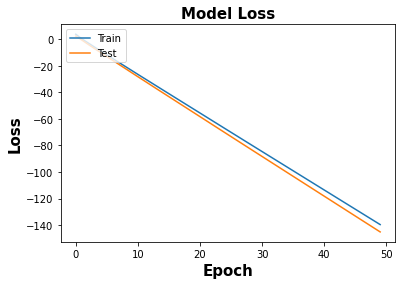

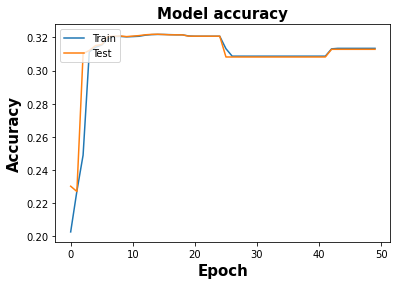

In [16]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[[4.4868290e-01, 1.7875808e-01, 3.6469573e-04, ...,
         1.0425194e-17, 2.1424612e-01, 5.3222891e-02]],

       [[4.4868290e-01, 1.7875808e-01, 3.6469573e-04, ...,
         1.0425194e-17, 2.1424612e-01, 5.3222891e-02]],

       [[4.4868290e-01, 1.7875808e-01, 3.6469573e-04, ...,
         1.0425194e-17, 2.1424612e-01, 5.3222891e-02]],

       ...,

       [[5.2646601e-01, 8.0907160e-01, 9.9959964e-01, ...,
         1.0000000e+00, 1.5654401e-01, 1.8934366e-01]],

       [[4.4868290e-01, 1.7875808e-01, 3.6469573e-04, ...,
         1.0425194e-17, 2.1424612e-01, 5.3222891e-02]],

       [[4.4868290e-01, 1.7875808e-01, 3.6469573e-04, ...,
         1.0425194e-17, 2.1424612e-01, 5.3222891e-02]]], dtype=float32)

In [18]:
y_test

array([[[-5.5306183e+01,  3.0651539e+01,  2.6809818e+02, ...,
         -3.2125660e+01, -6.0041463e-01,  3.5637581e-01]],

       [[-4.0849674e+01, -3.2327366e+01,  4.0117168e+01, ...,
         -1.6759521e+01, -4.3478742e-01, -4.7449446e-01]],

       [[-5.3128677e+01,  6.3768907e+00, -5.4489349e+02, ...,
          2.2194275e+01,  4.7399120e+00, -9.3144459e-01]],

       ...,

       [[-8.7860565e+01, -3.0838274e+01, -4.4087744e+02, ...,
          6.9052582e+01,  3.2712939e-01, -9.7863328e-01]],

       [[-5.1226246e+01,  1.9645956e+01,  1.7010298e+02, ...,
         -2.2718235e+01, -1.5850252e+00, -2.5478810e-01]],

       [[-9.5646217e+01, -6.0683804e+01,  1.5412691e+02, ...,
         -2.9311705e+01, -8.5079241e-01,  3.8455275e-01]]], dtype=float32)

In [19]:
y_test=y_test[:,0]
y_test_pred=y_test_pred[:,0]

In [20]:
from numpy import savetxt
savetxt('cnn_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [21]:
from numpy import savetxt
savetxt('cnn_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed